In [1]:
import importlib
import os
from joblib import dump, load

import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"

np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

# https://github.com/tensorflow/text/issues/476

INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


C:\Users\vince\AppData\Roaming\Python\Python37\site-packages\tensorflow_addons\utils\ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.6.0-dev20210413). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
# 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
# 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [3]:
df_base = pd.read_pickle(data_path + 'bs4.pkl')
df_top = pd.read_pickle(data_path + 'Top_Tags.pkl')

df_base_test = pd.read_pickle(data_path + 'bs4_test.pkl')
df_top_test = pd.read_pickle(data_path + 'Top_Tags_test.pkl')

In [4]:
mlb = MultiLabelBinarizer()
df_tags = pd.read_pickle(data_path + 'Top_Tags.pkl')
df_tags_test = pd.read_pickle(data_path + 'Top_Tags_test.pkl')
df_tags_full = pd.concat([df_tags,df_tags_test])
mlb.fit_transform(df_tags_full['Tags_T50'])

y_tags = mlb.transform(df_tags['Tags_T50'])
y_tags_test = mlb.transform(df_tags_test['Tags_T50'])

y_tag_python = y_tags[:,np.where(mlb.classes_=="python")]

In [5]:
text_test = ['help on python array']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2393  2006 18750  9140   102     0     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [9]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 128

# dataset =  tf.data.Dataset.from_tensor_slices((df['Body'][:COUNT], y_tags[:COUNT]))
dataset =  tf.data.Dataset.from_tensor_slices((df_base['Bs4_Body'][:COUNT], y_tags[:COUNT]))


dataset_train, dataset_valid = dataset.take(dataset.cardinality().numpy()*SPLIT_RATIO), dataset.skip(dataset.cardinality().numpy()*SPLIT_RATIO)
data_train = dataset_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
data_valid = dataset_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_test =  tf.data.Dataset.from_tensor_slices((df_base_test['Bs4_Body'], y_tags_test))
data_test = dataset_test.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [10]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.4 )(net)
#     net = tf.keras.layers.Dense(48, activation='relu', name='HIDDEN_1')(net)
#     net = tf.keras.layers.Dropout(0.25)(net)
    net = tf.keras.layers.Dense(51, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)


# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

In [11]:
loss = tf.keras.losses.BinaryCrossentropy(
#     from_logits=True
    )
# metrics = tf.metrics.BinaryAccuracy()
metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [12]:
epochs = 7
classifier_model = build_classifier_model()
steps_per_epoch = tf.data.experimental.cardinality(data_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [13]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics,
#                          metrics=['AUC'],
                        )

In [11]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=2,
    restore_best_weights=True,
    )

history = classifier_model.fit(x=data_train,
        validation_data=data_valid,
        epochs=epochs,
        callbacks=[es_callback],
                              )

Epoch 1/7
2411/2411 [==============================] - 558s 229ms/step - loss: 0.1981 - patr: 0.1183 - recall: 0.1863 - auc: 0.7371 - fp: 48174.9971 - fn: 45653.2032 - tp: 11709.5543 - accuracy: 0.9226 - precision: 0.1669 - val_loss: 0.0604 - val_patr: 0.8023 - val_recall: 0.4507 - val_auc: 0.9578 - val_fp: 3983.0000 - val_fn: 15807.0000 - val_tp: 12970.0000 - val_accuracy: 0.9799 - val_precision: 0.7651
Epoch 2/7
2411/2411 [==============================] - 547s 227ms/step - loss: 0.0619 - patr: 0.7718 - recall: 0.4641 - auc: 0.9554 - fp: 10248.1621 - fn: 30130.1866 - tp: 27232.6833 - accuracy: 0.9793 - precision: 0.7227 - val_loss: 0.0565 - val_patr: 0.8394 - val_recall: 0.5450 - val_auc: 0.9635 - val_fp: 5760.0000 - val_fn: 13093.0000 - val_tp: 15684.0000 - val_accuracy: 0.9808 - val_precision: 0.7314
Epoch 3/7
2411/2411 [==============================] - 549s 228ms/step - loss: 0.0521 - patr: 0.8564 - recall: 0.5515 - auc: 0.9697 - fp: 9876.3590 - fn: 25157.9797 - tp: 32205.6306 - 

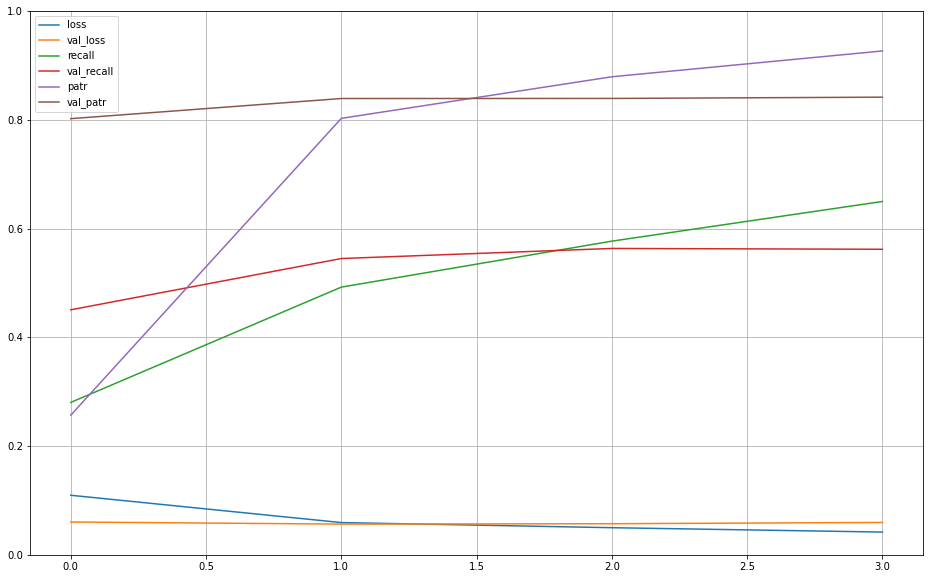

In [12]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
save=False
if save:
    classifier_model.save(model_path + "BERT_model", overwrite=True, include_optimizer=True)
    saved_model = classifier_model
#     model.save_weights(model_path + "LSTM_weights")
else:
    # Not yet functional, need custom object saved conforming to TF specs
    saved_model = tf.keras.models.load_model(model_path + "BERT_model")

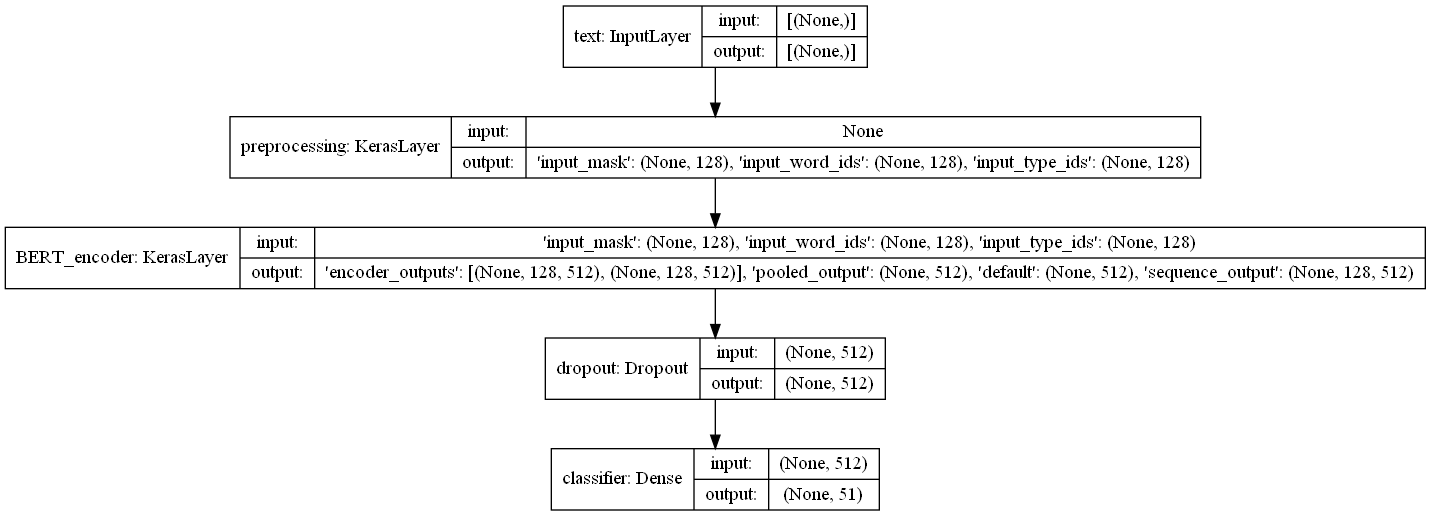

In [15]:
tf.keras.utils.plot_model(saved_model, show_shapes=True,  dpi=96, to_file=data_path + "pict_MODEL_BERT.png")

In [16]:
classifier_model.evaluate(data_test)

433/433 [==============================] - 56s 130ms/step - loss: 0.0568 - patr: 0.8342 - recall: 0.5452 - auc: 0.9636 - fp: 4335.0000 - fn: 9469.0000 - tp: 11351.0000 - accuracy: 0.9804 - precision: 0.7236


[0.0568210631608963,
 0.8341984152793884,
 0.5451969504356384,
 0.9636111259460449,
 4335.0,
 9469.0,
 11351.0,
 0.980437695980072,
 0.7236388921737671]

In [17]:
classifier_model.evaluate(data_valid)

603/603 [==============================] - 77s 128ms/step - loss: 0.0566 - patr: 0.8348 - recall: 0.5416 - auc: 0.9633 - fp: 5809.0000 - fn: 13190.0000 - tp: 15587.0000 - accuracy: 0.9807 - precision: 0.7285


[0.05656689777970314,
 0.8347939252853394,
 0.5416478514671326,
 0.9633365273475647,
 5809.0,
 13190.0,
 15587.0,
 0.9806822538375854,
 0.7285006642341614]